In [1]:
from scipy.stats import bootstrap
from hierarchy import *
from benlib.plot import scatter_cc, remove_frames
set_publication_figure_defaults()

clusters = Clusters(12)
clusters.summarize()
clusters.mark_excluded_units()
fig_num = 4

NR <= 200:
Anaesthetised: ic: 178, mgb:  84, mgbm:   0, ac: 298, total:  560
Awake:         ic: 262, mgb: 278, mgbm:   0, ac: 341, total:  881
Total:         ic: 440, mgb: 362, mgbm:   0, ac: 639, total: 1441

NR > 200:
Anaesthetised: ic:   7, mgb:  27, mgbm:   0, ac:  55, total:   89
Awake:         ic:   1, mgb:  29, mgbm:   0, ac:   1, total:   31
Total:         ic:   8, mgb:  56, mgbm:   0, ac:  56, total:  120

Loading "coch kernels; 16 folds; ElNet"
Fieldname: coch_kernel_main
Found single data file with 1561 clusters
All results present (1561 clusters)

Loading "main elnet a2a kernels (NR=200; all units; all valid data; 1 fold)"
Fieldname: a2a_kernels_main
/Users/ben/projects/michael-data/hierarchy/results/stim-12/a2a_kernels--state=anaesthetised-awake--subset=valid20-all--combo_lens=1-2-3--n_h=8--n_fut=5--k_folds=16--fold_idxes_to_include=15--noiseratio=200--regress=ElNet
Found data files with 1441 clusters
All results present (1441 clusters)

Loading "coch kernels; 16 folds; El

In [2]:
clusters.load_analyses(['coch_kernel_main', 'a2a_kernels_main',
                        'coch_kernel_sigmoid_main', 'a2a_kernels_sigmoid_main'])

Loading "coch kernels; 16 folds; ElNet"
Fieldname: coch_kernel_main
Found single data file with 1561 clusters
All results present (1561 clusters)

Loading "main elnet a2a kernels (NR=200; all units; all valid data; 1 fold)"
Fieldname: a2a_kernels_main
/Users/ben/projects/michael-data/hierarchy/results/stim-12/a2a_kernels--state=anaesthetised-awake--subset=valid20-all--combo_lens=1-2-3--n_h=8--n_fut=5--k_folds=16--fold_idxes_to_include=15--noiseratio=200--regress=ElNet
Found data files with 1441 clusters
All results present (1441 clusters)

Loading "coch kernels; 16 folds; ElNet; LN (sigmoid)"
Fieldname: coch_kernel_sigmoid_main
Found single data file with 1561 clusters
All results present (1561 clusters)

Loading "a2a kernels; 1 fold; ElNet; LN (sigmoid)"
Fieldname: a2a_kernels_sigmoid_main
Found single data file with 1441 clusters
** Missing more than 15 results **



In [3]:
def coch_kernel_main_ln_cc_norm_test(cluster, regressor_area=None):
    return cluster['coch_kernel_sigmoid_main']['sigmoid_fits'][-1]['sigmoid']['cc_norm_test'][0]

def a2a_kernels_main_ln_cc_norm_test(cluster, regressor_area):
    return cluster['a2a_kernels_sigmoid_main']['sigmoid_fits'][regressor_area][-1]['sigmoid']['cc_norm_test'][0]

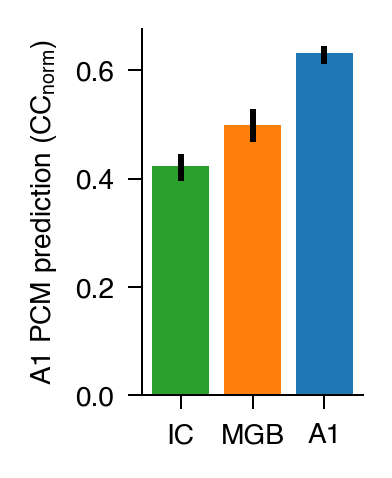

In [4]:
# median values for bar plot -- using LN model / sigmoid fits
import matplotlib

fig = plt.figure(figsize=(4.2/2.54*.6,4.2/2.54))

# panel A -- bar plot
# plt.subplot(1,3,1)

sel = clusters.select_data(brain_area='ic', noiseratio=200, excluded=False)
cc_norm_a2a_ic = [a2a_kernels_main_ln_cc_norm_test(cl, 'ac') for cl in sel]

sel = clusters.select_data(brain_area='mgb', noiseratio=200, excluded=False)
cc_norm_a2a_mgb = [a2a_kernels_main_ln_cc_norm_test(cl, 'ac') for cl in sel]

sel = clusters.select_data(brain_area='ac', noiseratio=200, excluded=False)
cc_norm_a2a_ac = [a2a_kernels_main_ln_cc_norm_test(cl, 'ac') for cl in sel]

data = [cc_norm_a2a_ic, cc_norm_a2a_mgb, cc_norm_a2a_ac]

mdn = [np.median(d) for d in data]
ci = [bootstrap((d,), np.median) for d in data]
err = [(m-c.confidence_interval.low, c.confidence_interval.high-m) for m,c in zip(mdn,ci)]
err_stack = np.vstack(err).T

plt.bar([0,1,2],
        mdn,
        yerr=err_stack,
        color=[BRAIN_AREA_COLORS['ic'], BRAIN_AREA_COLORS['mgb'], BRAIN_AREA_COLORS['ac']],
        capsize=0, error_kw={'elinewidth': 1.5})

# plt.axhline(coch_mdn, color='k', linestyle='--')
plt.xticks([0,1,2], [AREA_LABELS['ic'], AREA_LABELS['mgb'], AREA_LABELS['ac']])

plt.ylabel('%s PCM prediction ($CC_{norm}$)' % AREA_LABELS['ac'])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig('figure-%d-bar.pdf' % fig_num, bbox_inches='tight')

In [5]:
# IC vs MGB
kruskal(cc_norm_a2a_ic, cc_norm_a2a_mgb)

KruskalResult(statistic=21.209995094651276, pvalue=4.116123673775397e-06)

In [6]:
# MGB vs AC
kruskal(cc_norm_a2a_mgb, cc_norm_a2a_ac)

KruskalResult(statistic=107.05880676878314, pvalue=4.321538509183823e-25)

In [7]:
# IC vs AC
kruskal(cc_norm_a2a_ic, cc_norm_a2a_ac)

KruskalResult(statistic=224.55229577712316, pvalue=9.19299157208156e-51)

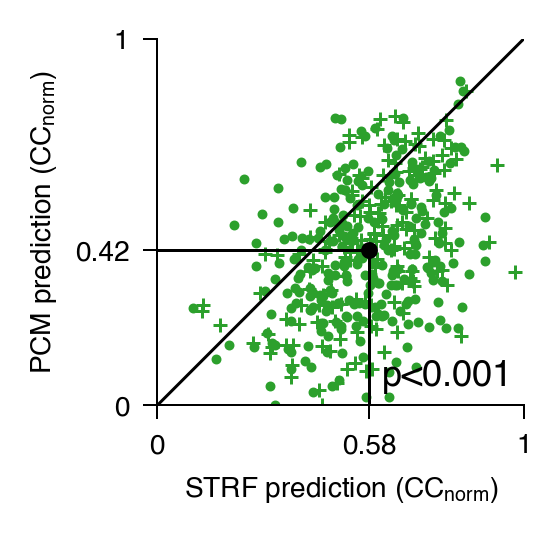

In [8]:
plt.figure(figsize=(4.2/2.54,4.2/2.54))

# panel B - scatter

# Cochleagram vs AC A2A prediction for IC units -- with awake vs anaesthetised symbols
# awake is dot, anesthetised is + 

# PCM vs cochleagram -- AC -> IC

target_area = 'ic'
regressor_area = 'ac'
awake = clusters.select_data(brain_area=target_area, noiseratio=200,
                             state='awake', excluded=False)
anaesthetised = clusters.select_data(brain_area=target_area, noiseratio=200,
                             state='anaesthetised', excluded=False)
x_data = [[coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in awake],
          [coch_kernel_main_ln_cc_norm_test(cl, regressor_area) for cl in anaesthetised]]
y_data = [[a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in awake],
          [a2a_kernels_main_ln_cc_norm_test(cl, regressor_area) for cl in anaesthetised]]
scatter_cc_multi(x_data, y_data, colors=BRAIN_AREA_COLORS['ic'],
           p_value=True, accept_nans=False)

plt.xlabel('STRF prediction ($CC_{norm}$)')
plt.ylabel('PCM prediction ($CC_{norm}$)')

plt.savefig('figure-%d-scatter.pdf' % fig_num)

0.2288864270986799


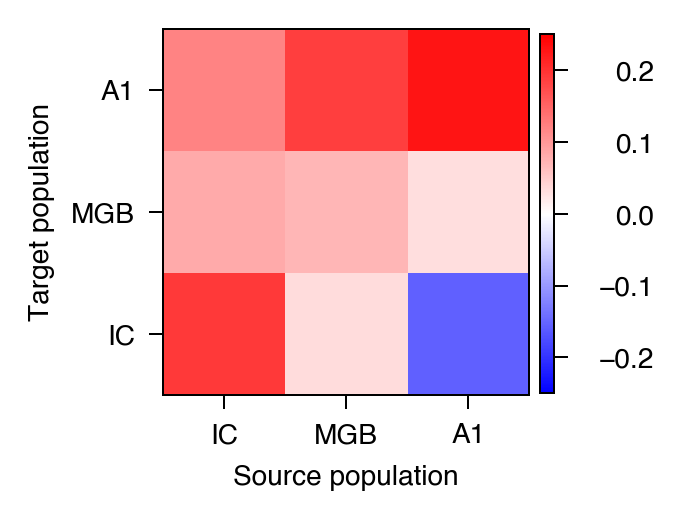

In [9]:
# Panel C - executive summary
# 3x3 summary ln/sigmoid

plt.figure(figsize=(4.2/2.54,4.2/2.54))
max_colorbar_value = 0.25
plot_3x3_summary(clusters, clusters.brain_areas, {'noiseratio': 200},
                 x_func=coch_kernel_main_ln_cc_norm_test,
                 y_func=a2a_kernels_main_ln_cc_norm_test,
                 cmap_max=max_colorbar_value)

# steps = np.array([.5, .5, 1.5, 1.5, 2.5])
# ctr = 1
# offset = .9
# plt.plot(steps, steps[::-1], ls='-', c='gray', lw=1.5, label='_nolegend_')
# plt.plot(2-steps, 2-steps[::-1], ls='-', c='gray', lw=1.5, label='_nolegend_')
# plt.text(ctr+offset, ctr+offset, 'ASCENDING', size=6, ha='center', va='center', rotation=45, c='k')
# plt.text(ctr-offset, ctr-offset, 'DESCENDING', size=6, ha='center', va='center', rotation=45, c='k')

cb_ax = plt.gcf().add_axes([.92,.114,.03,.754])

normalise_colorbar = matplotlib.colors.Normalize(-max_colorbar_value, max_colorbar_value)
cb = plt.gcf().colorbar(matplotlib.cm.ScalarMappable(cmap='bwr', norm=normalise_colorbar),
                        orientation='vertical', cax=cb_ax)
# plt.colorbar()

# cb = plt.gcf().colorbar
# print(cb)
for t in cb.ax.get_yticklabels():
    t.set_horizontalalignment('right')   
    t.set_x(6)

plt.savefig('figure-%d-executive-summary.pdf' % fig_num, bbox_inches='tight')